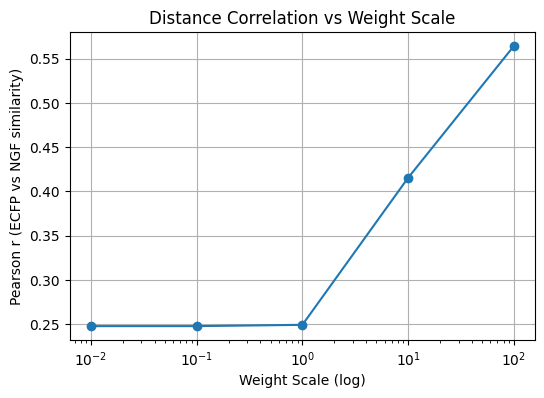

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import NeuralFingerprint
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from itertools import combinations
from scipy.stats import pearsonr

# --- 1) Load ESOL and compute ECFP4 ---
dataset = MoleculeNet(root='data/MoleculeNet', name='esol')
smiles_list = [data.smiles for data in dataset]

def ecfp4_fp(smi, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

fps_ecfp = np.stack([ecfp4_fp(smi) for smi in smiles_list])

# Sample 2000 random pairs
num_graphs = len(fps_ecfp)
all_pairs = list(combinations(range(num_graphs), 2))
rng = np.random.default_rng(0)
pairs = rng.choice(len(all_pairs), size=2000, replace=False)
selected_pairs = [all_pairs[i] for i in pairs]

# Precompute ECFP Tanimoto
def tanimoto_sim(a, b):
    # compute similarity from binary arrays
    return DataStructs.TanimotoSimilarity(
        AllChem.DataStructs.CreateFromBitString(''.join(map(str, a.tolist()))),
        AllChem.DataStructs.CreateFromBitString(''.join(map(str, b.tolist())))
    )

ecfp_sims = [tanimoto_sim(fps_ecfp[i], fps_ecfp[j]) for i, j in selected_pairs]

# --- 2) NGF embeddings function with detach() ---
def compute_ngf_embeddings(scale, dataset, batch_size=64):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    ngf = NeuralFingerprint(
        in_channels=dataset.num_node_features,
        hidden_channels=64,
        out_channels=128,
        num_layers=3
    )
    # scale weights
    with torch.no_grad():
        for p in ngf.parameters():
            p.mul_(scale)
    ngf.eval()

    embs = []
    with torch.no_grad():
        for batch in loader:
            e = ngf(batch.x.float(), batch.edge_index, batch.batch)
            # detach before numpy
            embs.append(e.detach().cpu().numpy())
    return np.vstack(embs)

# Continuous Tanimoto
def continuous_tanimoto(x, y):
    dot = np.dot(x, y)
    return dot / (np.dot(x, x) + np.dot(y, y) - dot + 1e-8)

# --- 3) Loop over scales and compute Pearson r ---
scales = [0.01, 0.1, 1, 10, 100]
r_values = []
for scale in scales:
    emb = compute_ngf_embeddings(scale, dataset)
    ngf_sims = [continuous_tanimoto(emb[i], emb[j]) for i, j in selected_pairs]
    r, _ = pearsonr(ecfp_sims, ngf_sims)
    r_values.append(r)

# --- 4) Plot ---
plt.figure(figsize=(6, 4))
plt.plot(scales, r_values, marker='o')
plt.xscale('log')
plt.xlabel('Weight Scale (log)')
plt.ylabel('Pearson r (ECFP vs NGF similarity)')
plt.title('Distance Correlation vs Weight Scale')
plt.grid(True)
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import NeuralFingerprint
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem


# 1) Load full ESOL and sample 200 molecules
full = MoleculeNet(root='data/MoleculeNet', name='esol')
rng = np.random.default_rng(1)
idx_sample = rng.choice(len(full), size=200, replace=False)
subset = [full[i] for i in idx_sample]

# 2) Compute ECFP4 bit-vectors
def ecfp4_fp(mol, radius=2, nBits=2048):
    bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(bitvect, arr)
    return arr

mols     = [Chem.MolFromSmiles(d.smiles) for d in subset]
fps_ecfp = np.stack([ecfp4_fp(m) for m in mols])

# 3) Build 1000 random pairs (i,j)
all_pairs = list(combinations(range(200), 2))
sample_idxs = rng.choice(len(all_pairs), size=1000, replace=False)
selected_pairs = [all_pairs[i] for i in sample_idxs]

# 4) Precompute ECFP Tanimoto similarities
def tanimoto_sim(a, b):
    bv_a = Chem.rdchem.ExplicitBitVect(len(a))
    bv_b = Chem.rdchem.ExplicitBitVect(len(b))
    for idx, bit in enumerate(a): bv_a.SetBit(idx) if bit else None
    for idx, bit in enumerate(b): bv_b.SetBit(idx) if bit else None
    return DataStructs.TanimotoSimilarity(bv_a, bv_b)

ecfp_sims = np.array([tanimoto_sim(fps_ecfp[i], fps_ecfp[j])
                      for i, j in selected_pairs])

# 5) Compute frozen NGF embeddings
loader = DataLoader(subset, batch_size=32, shuffle=False)
ngf = NeuralFingerprint(
    in_channels=full.num_node_features,
    hidden_channels=64,
    out_channels=128,
    num_layers=3
)
with torch.no_grad():
    for p in ngf.parameters(): p.mul_(1.0)
ngf.eval()

embs = []
with torch.no_grad():
    for batch in loader:
        e = ngf(batch.x.float(), batch.edge_index, batch.batch)
        embs.append(e.cpu().numpy())
emb = np.vstack(embs)  # shape [200,128]

# 6) Compute continuous‐Tanimoto on NGF
def cont_tanimoto(x, y):
    dot = np.dot(x, y)
    return dot / (np.dot(x, x) + np.dot(y, y) - dot + 1e-8)

ngf_sims = np.array([cont_tanimoto(emb[i], emb[j])
                     for i, j in selected_pairs])

# 7) Scatter‐plot
plt.figure(figsize=(6,6))
plt.scatter(ecfp_sims, ngf_sims, alpha=0.5, s=10)
plt.xlabel('ECFP4 Tanimoto Similarity')
plt.ylabel('Frozen NGF Continuous Tanimoto')
plt.title('ECFP vs. Frozen NGF Similarities (200‐molecule sample)')
plt.grid(True)
plt.show()


AttributeError: module 'rdkit.Chem.rdchem' has no attribute 'ExplicitBitVect'

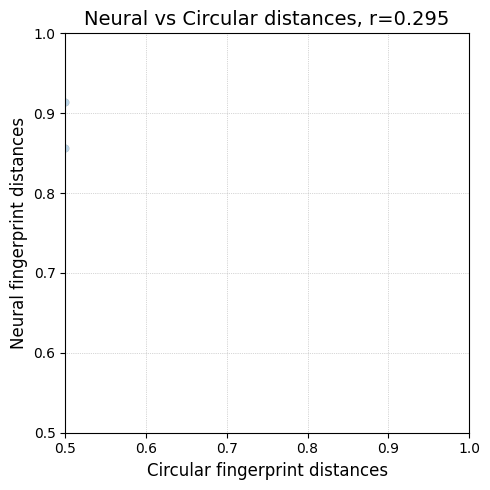

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import NeuralFingerprint
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from itertools import combinations
import torch

# 1) Load full ESOL and sample 200 molecules
full = MoleculeNet(root='data/MoleculeNet', name='esol')
rng = np.random.default_rng(1)
idx_sample = rng.choice(len(full), size=200, replace=False)
subset = [full[i] for i in idx_sample]

# 2) Compute and store the RDKit bit-vectors
fps_ecfp = [AllChem.GetMorganFingerprintAsBitVect(
                Chem.MolFromSmiles(data.smiles),
                radius=2,
                nBits=2048)
            for data in subset]

# 3) Build 1,000 random pairs
all_pairs = list(combinations(range(200), 2))
sample_idxs = rng.choice(len(all_pairs), size=1000, replace=False)
selected_pairs = [all_pairs[i] for i in sample_idxs]

# 4) Precompute ECFP Tanimoto similarities
ecfp_dists = np.array([
    DataStructs.TanimotoSimilarity(fps_ecfp[i], fps_ecfp[j])
    for i, j in selected_pairs
])

# 5) Compute frozen NGF embeddings
loader = DataLoader(subset, batch_size=32, shuffle=False)
ngf = NeuralFingerprint(
    in_channels=full.num_node_features,
    hidden_channels=64,
    out_channels=128,
    num_layers=3
)
# freeze & (optionally) scale
with torch.no_grad():
    for p in ngf.parameters(): p.mul_(1.0)
ngf.eval()

embs = []
with torch.no_grad():
    for batch in loader:
        e = ngf(batch.x.float(), batch.edge_index, batch.batch)
        embs.append(e.cpu().numpy())
emb = np.vstack(embs)  # shape [200, 128]

# 6) Compute Continuous Tanimoto on NGF embeddings
def cont_tanimoto(x, y):
    dot = np.dot(x, y)
    return dot / (np.dot(x, x) + np.dot(y, y) - dot + 1e-8)

ngf_dists = np.array([
    cont_tanimoto(emb[i], emb[j])
    for i, j in selected_pairs
])



# 1) Compute Pearson r
r, _ = pearsonr(ecfp_dists, ngf_dists)

# 2) Create scatterplot
plt.figure(figsize=(5,5))
plt.scatter(
    ecfp_dists, 
    ngf_dists,
    s=30,                # size of each point
    alpha=0.3,           # transparency
    edgecolors='black',  # thin black outline
    linewidths=0.2,
    facecolor='C0'
)

# 3) Labels, limits, grid
plt.xlabel("Circular fingerprint distances", fontsize=12)
plt.ylabel("Neural fingerprint distances", fontsize=12)
plt.xlim(0.5, 1.0)
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle=':', linewidth=0.5)

# 4) Title with r-value
plt.title(f"Neural vs Circular distances, r={r:.3f}", fontsize=14)

plt.tight_layout()
plt.show()



In [22]:
from ngf_model import NeuralGraphFingerprint
from data import get_esol_ecfp4_datasets, ESOL_ECFP, ESOL_GNN
from torch_geometric.loader import DataLoader
import torch
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from itertools import combinations

from torch_geometric.datasets import MoleculeNet
dataset = MoleculeNet(root='data/MoleculeNet', name='ESOL')

model = NeuralGraphFingerprint(
    in_channels=dataset.num_features,
    hidden_dim=128,
    fingerprint_dim=2048,
    num_layers=2
)

loader = DataLoader(dataset, batch_size=64, shuffle=False)

for p in model.parameters():
    p.requires_grad = False
    
all_embs = []
with torch.no_grad():
    for data in loader:
        emb = model(data)  
        all_embs.append(emb.cpu())

emb_mat = torch.cat(all_embs, dim=0).numpy()  # shape [300,128]
        
#ecfp4 = ESOL_ECFP(root='data/ESOL_ECFP', radius=2, nBits=2048)
# 1) Load ESOL and sample 300 molecules
full_ds = MoleculeNet(root='data/MoleculeNet', name='esol')
rng = np.random.default_rng(42)

# 2) Compute RDKit ECFP4 bit-vectors
fps_ecfp = ESOL_ECFP(root='data/ESOL_ECFP', radius=2, nBits=2048)

# 3) Build 1500 random pairs
all_pairs    = list(combinations(range(len(fps_ecfp)), 2))
sample_idxs  = rng.choice(len(all_pairs), size=2000, replace=False)
pairs        = [all_pairs[i] for i in sample_idxs]

# 4) ECFP distances = 1 − Tanimoto similarity
ecfp_dists = np.array([
    1.0 - DataStructs.TanimotoSimilarity(fps_ecfp[i], fps_ecfp[j])
    for i, j in pairs
])



# 6) Continuous‐Tanimoto distances = 1 − cont_sim
def cont_sim(x, y):
    dot = x.dot(y)
    return dot / (x.dot(x) + y.dot(y) - dot + 1e-8)

ngf_dists = np.array([
    1.0 - cont_sim(emb_mat[i], emb_mat[j])
    for i, j in pairs
])

# 7) Pearson r
r, _ = pearsonr(ecfp_dists, ngf_dists)

# 8) Plot
plt.figure(figsize=(5,5))
plt.scatter(
    ecfp_dists, 
    ngf_dists, 
    s=20, 
    alpha=0.4, 
    edgecolors='black', 
    linewidths=0.2, 
    facecolor='C0'
)
plt.xlabel("Circular fingerprint distances", fontsize=12)
plt.ylabel("Neural fingerprint distances",   fontsize=12)
plt.xlim(0.5, 1.0)
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.title(f"Neural vs Circular distances, $r={r:.3f}$", fontsize=14)
plt.tight_layout()
plt.show()

ArgumentError: Python argument types in
    rdkit.DataStructs.cDataStructs.TanimotoSimilarity(Data, Data)
did not match C++ signature:
    TanimotoSimilarity(class RDKit::SparseIntVect<unsigned __int64> siv1, class RDKit::SparseIntVect<unsigned __int64> siv2, bool returnDistance=False, double bounds=0.0)
    TanimotoSimilarity(class RDKit::SparseIntVect<unsigned int> siv1, class RDKit::SparseIntVect<unsigned int> siv2, bool returnDistance=False, double bounds=0.0)
    TanimotoSimilarity(class RDKit::SparseIntVect<__int64> siv1, class RDKit::SparseIntVect<__int64> siv2, bool returnDistance=False, double bounds=0.0)
    TanimotoSimilarity(class RDKit::SparseIntVect<int> siv1, class RDKit::SparseIntVect<int> siv2, bool returnDistance=False, double bounds=0.0)
    TanimotoSimilarity(class ExplicitBitVect bv1, class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > pkl, bool returnDistance=0)
    TanimotoSimilarity(class SparseBitVect bv1, class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > pkl, bool returnDistance=0)
    TanimotoSimilarity(class ExplicitBitVect bv1, class ExplicitBitVect bv2, bool returnDistance=0)
    TanimotoSimilarity(class SparseBitVect bv1, class SparseBitVect bv2, bool returnDistance=0)

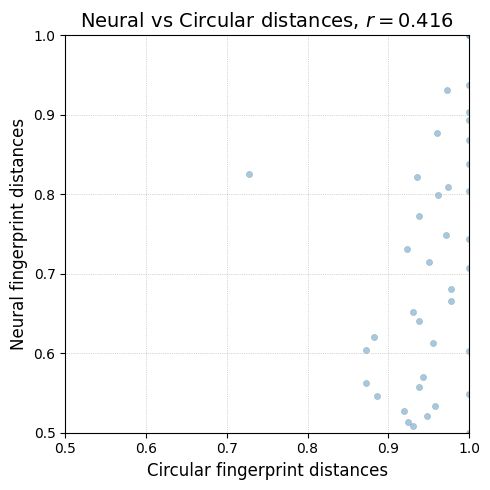

In [41]:
from ngf_model import NeuralGraphFingerprint
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from itertools import combinations
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import hashlib
from rdkit.Chem import rdFingerprintGenerator

def hash_atom_info(atom):
    features = (
        atom.GetAtomicNum(),
        atom.GetTotalDegree(),
        atom.GetTotalNumHs(),
        atom.GetImplicitValence(),
        atom.GetIsAromatic(),
        #atom.IsInRing()
    )
    s = str(features)
    h = hashlib.sha1(s.encode('utf-8')).hexdigest()
    return int(h, 16) & 0xFFFFFFFF  # 32-bit

def hash_tuple(t):
    h = hashlib.sha1(str(t).encode('utf-8')).hexdigest()
    return int(h, 16) & 0xFFFFFFFF

def get_custom_invariants(mol):
    """Compute a list of integer invariants, one per atom in the molecule,
    using a tuple of properties. Adjust the tuple to include the properties you need."""
    invariants = []
    for atom in mol.GetAtoms():
        invariants.append(hash_atom_info(atom))
    return invariants

def compute_ecfp_fp(smiles: str, radius: int, nBits: int):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")

    invariants = get_custom_invariants(mol)
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
    return mfpgen.GetFingerprint(mol)
# =======================
# 1. Load ESOL dataset
# =======================
dataset = MoleculeNet(root='data/MoleculeNet', name='ESOL')
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# =======================
# 2. Define NGF model
# =======================
model = NeuralGraphFingerprint(
    in_channels=dataset.num_features,
    hidden_dim=64,
    fingerprint_dim=128,
    num_layers=2
)

# Freeze parameters (no training)
for p in model.parameters():
    p.requires_grad = False

# =======================
# 3. Get NGF embeddings
# =======================
model.eval()
all_embs = []
with torch.no_grad():
    for data in loader:
        emb = model(data)  # [batch_size, fingerprint_dim]
        all_embs.append(emb.cpu())
emb_mat = torch.cat(all_embs, dim=0).numpy()  # shape [N, 2048]

# =======================
# 4. Compute ECFP4 fingerprints
# =======================
def smiles_to_ecfp(smiles, radius=2, nBits=2048):
    return compute_ecfp_fp(smiles=smiles, radius = radius, nBits=nBits)

'''def smiles_to_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)'''

# Get SMILES strings (in same order as dataset)
smiles_list = [dataset[i].smiles for i in range(len(dataset))]
fps_ecfp = [smiles_to_ecfp(smi) for smi in smiles_list]

# =======================
# 5. Build random pairs
# =======================
rng = np.random.default_rng(42)
all_pairs = list(combinations(range(len(fps_ecfp)), 2))
sample_idxs = rng.choice(len(all_pairs), size=100, replace=False)
pairs = [all_pairs[i] for i in sample_idxs]

# =======================
# 6. Compute ECFP distances
# =======================
ecfp_dists = np.array([
    1.0 - DataStructs.TanimotoSimilarity(fps_ecfp[i], fps_ecfp[j])
    for i, j in pairs
])

# =======================
# 7. Compute NGF distances
# =======================
def cont_tanimoto(x, y):
    dot = np.dot(x, y)
    return dot / (np.dot(x, x) + np.dot(y, y) - dot + 1e-8)

ngf_dists = np.array([
    1.0 - cont_tanimoto(emb_mat[i], emb_mat[j])
    for i, j in pairs
])

# =======================
# 8. Compute Pearson correlation
# =======================
r, _ = pearsonr(ecfp_dists, ngf_dists)

# =======================
# 9. Plot
# =======================
plt.figure(figsize=(5, 5))
plt.scatter(
    ecfp_dists,
    ngf_dists,
    s=20,
    alpha=0.4,
    edgecolors='black',
    linewidths=0.2,
    facecolor='C0'
)
plt.xlabel("Circular fingerprint distances", fontsize=12)
plt.ylabel("Neural fingerprint distances", fontsize=12)
plt.xlim(0.5, 1.0)
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.title(f"Neural vs Circular distances, $r={r:.3f}$", fontsize=14)
plt.tight_layout()
plt.show()
